In [1]:
cd ~/data/landsat

/media/wintermute/data/landsat


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt = plotter(backend='agg')
%matplotlib inline

In [4]:
import time
from shapely.geometry import Polygon
from PIL import Image, ImageDraw
import geopandas as gpd
Image.MAX_IMAGE_PIXELS = 1000000000
from pyproj import Proj
from matplotlib import cm
import scipy.sparse as sp

In [5]:
import location_tools

In [6]:
def make_rectangle(xlo, xhi, ylo, yhi, poly=True):
    rect = [(xlo, ylo), (xhi, ylo), (xhi, yhi), (xlo, yhi), (xlo, ylo)]
    return Polygon(rect) if poly else rect

## Load Data

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [8]:
scenes = pd.read_csv('targets/google_scenes_2002_cloud.csv', parse_dates=['DATE_ACQUIRED'])
print(len(scenes))

1465


## Imagery Coverage

In [9]:
boxes = scenes[['WEST_LON', 'EAST_LON', 'SOUTH_LAT', 'NORTH_LAT']]
boxes = gpd.GeoSeries(boxes.apply(lambda x: make_rectangle(*x), axis=1))
uboxes = gpd.GeoDataFrame({'geometry': gpd.GeoSeries(boxes.unary_union)})

In [10]:
lon_min, lon_max, lat_min, lat_max = 55, 150, 0, 70
rect = make_rectangle(lon_min, lon_max, lat_min, lat_max)
area = gpd.GeoDataFrame({'geometry': gpd.GeoSeries(rect)})
crop = gpd.overlay(world.cx[lon_min:lon_max, lat_min:lat_max], area, how='intersection')

/home/doug/.local/lib/python3.7/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {} and None
  other.crs))


/home/doug/.local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


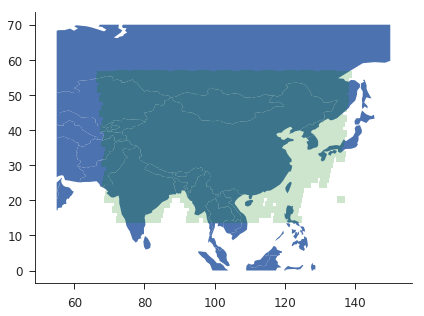

In [11]:
fig, ax = plt.subplots(figsize=(6, 4.5))
crop.plot(ax=ax);
# boxes.plot(ax=ax, color='r', alpha=0.2);
uboxes.plot(ax=ax, color='g', alpha=0.2);
plt.axis('equal');

## UTM Coverage

In [12]:
letters = 'CDEFGHJKLMNPQRSTUVWX'
fletter = {i: c for i, c in enumerate(letters)}
rletter = {c: i for i, c in enumerate(letters)}

def wgs2utm(lon_wgs, lat_wgs):
    idx_lon = int(round(lon_wgs/6.0 + 30.5))
    idx_lat = int(round(lat_wgs/8.0 + 9.5))
    utm_lon = ((idx_lon-1) % 60) + 1
    utm_lat = fletter[idx_lat]
    return f'{utm_lon}{utm_lat}'

# returns bottom left corner (cell is 6x8 degrees)
def utm2wgs(lon_utm, lat_utm):
    idx_lon = lon_utm - 1
    idx_lat = rletter[lat_utm]
    lon_wgs = 6*(idx_lon - 30)
    lat_wgs = 8*(idx_lat - 10)
    return lon_wgs, lat_wgs

In [13]:
utm_zones = [
                '45U',                        '50U','51U','52U','53U',
    '43T','44T','45T','46T','47T','48T','49T','50T','51T','52T','53T',
    '43S','44S','45S','46S','47S','48S','49S','50S','51S',
          '44R','45R','46R','47R','48R','49R','50R','51R',
                            '47Q','48Q','49Q','50Q'
]
utm_codes = [(int(z[:-1]), z[-1]) for z in utm_zones]
utm_base = [utm2wgs(lon, lat) for lon, lat in utm_codes]
utm_boxes = gpd.GeoSeries([make_rectangle(lon, lon+6, lat, lat+8) for lon, lat in utm_base])
utm_proj = {z: Proj(f'+proj=utm +zone={z}, +ellps=WGS84 +datum=WGS84 +units=m +no_defs') for z in utm_zones}
utm_func = lambda z, lon, lat, inverse=False: utm_proj[z](lon, lat, inverse=inverse)

/home/doug/.local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


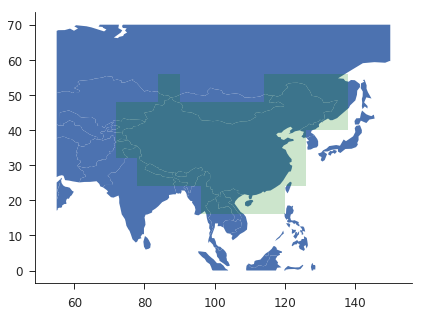

In [14]:
fig, ax = plt.subplots(figsize=(6, 4.5))
crop.plot(ax=ax);
utm_boxes.plot(ax=ax, color='g', alpha=0.2);
plt.axis('equal');

/home/doug/.local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


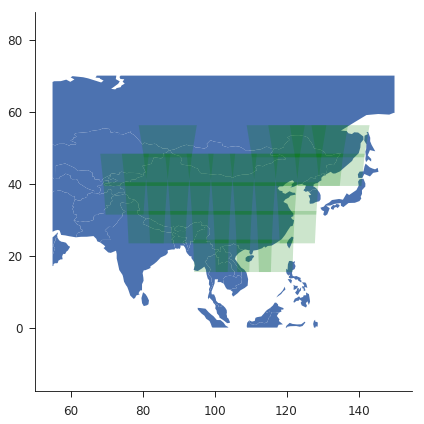

In [15]:
rad_x, rad_y = 500000, 500000
utm_centers_wgs = [(lon+3, lat+4) for lon, lat in utm_base]
utm_centers_utm = [utm_func(z, lon, lat) for z, (lon, lat) in zip(utm_zones, utm_centers_wgs)]
utm_radboxs_utm = [(lon-rad_x, lon+rad_x, lat-rad_y, lat+rad_y) for lon, lat in utm_centers_utm]
utm_radrect_utm = [make_rectangle(*x, poly=False) for x in utm_radboxs_utm]
utm_radrect_wgs = [[utm_func(z, *y, inverse=True) for y in x] for z, x in zip(utm_zones, utm_radrect_utm)]
utm_radpoly_wgs = gpd.GeoSeries([Polygon(x) for x in utm_radrect_wgs])
fig, ax = plt.subplots(figsize=(6, 6))
crop.plot(ax=ax);
utm_radpoly_wgs.plot(ax=ax, color='g', alpha=0.2);
#utm_boxes.loc[:3].plot(ax=ax, color='r', alpha=0.2);
plt.axis('equal');

## Firm Acquisition

In [30]:
# these should be WGS 84 datum (EPSG 3857)
x_lon, x_lat, proj = 116.390797, 39.916406, 'wgs-84' # beijing (forbidden city)
# x_lon, x_lat, proj = 116.406562, 39.882110, 'wgs' # beijing (temple of heaven)
# x_lon, x_lat, proj = 114.0665, 22.654437, 'bd-09' # huawei headquarters
# x_lon, x_lat, proj = 121.486958, 31.244277, 'wgs' # shanghai bund point - WGS84

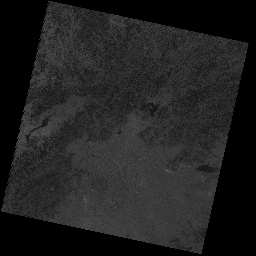

In [31]:
index = pd.read_csv('targets/google_scenes_2002_mincloud.csv')
x_pid = location_tools.find_scene(x_lon, x_lat, index)
im = Image.open(f'scenes/{x_pid}_B8.TIF')
im.resize((256, 256))

In [32]:
def regularize(image, wins_lo=0.01, wins_hi=0.99, chop=True):
    arr = np.asarray(image).flatten()
    vlo, vhi = np.quantile(arr, [wins_lo, wins_hi])
    mat = np.clip(arr, vlo, vhi).reshape(image.size)
    return Image.fromarray(mat)

/home/doug/.local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


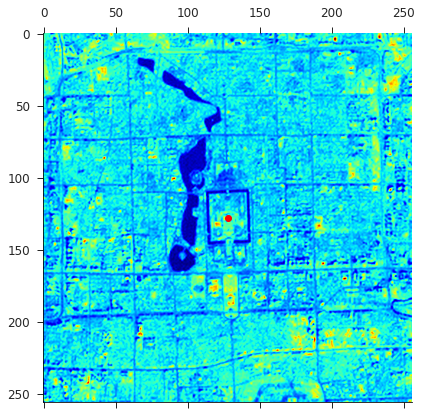

In [33]:
size = 256
fig, ax = plt.subplots(figsize=(6, 6))
tile = location_tools.extract_satelite_tile(x_lon, x_lat, index, rad=256, size=size, proj=proj, resample=Image.LANCZOS)
ax.matshow(tile, cmap=cm.jet, origin='upper', interpolation='lanczos')
ax.scatter([size/2], [size/2], c='r');

## Firm Cluster

In [21]:
coldefs = {
    'No': 'id',
    'longitude': 'lon_bd09',
    'latitude': 'lat_bd09',
}
census = pd.read_csv('/home/doug/data/cluster/census/census_2004_geocode.csv', usecols=coldefs)
census = census.rename(columns=coldefs)
census = census.dropna().drop_duplicates('id')
census['id'] = census['id'].astype(np.int)

In [22]:
utm_info = pd.read_csv('meta/utm_centers.csv', index_col='utm')

50Q
0.19731123141647894 0.7964573455891991
13154 53097


/home/doug/.local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


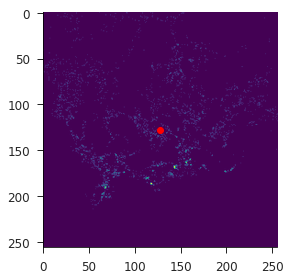

In [152]:
im = location_tools.extract_density_tile(finfo['lon_bd09'], finfo['lat_bd09'], rad=2048, size=256, proj='bd-09')
fig, ax = plt.subplots()
ax.imshow(np.asarray(im), origin='upper', interpolation='lanczos')
ax.scatter([128], [128], c='r');

50Q
0.19731123141647894 0.7964573455891991
13154 53097


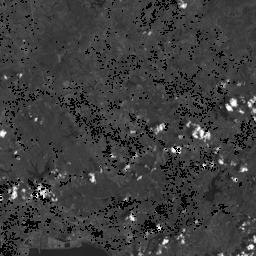

In [206]:
fidx = 271272 # huawei
# fidx = 601000
rad, size = 1024, 256
finfo = census[census['id']==fidx].iloc[0]
sat = location_tools.extract_satelite_tile(finfo['lon_bd09'], finfo['lat_bd09'], index, rad=rad, size=size, proj='bd-09')
den = location_tools.extract_density_tile(finfo['lon_bd09'], finfo['lat_bd09'], rad=rad, size=size, proj='bd-09')
dmask = Image.fromarray(255*(np.asarray(den)>0).astype(np.uint8))
sat.paste(den, (0, 0), dmask)
sat

## Tile Browsing

In [148]:
import glob
import ipywidgets as widgets
from ipywidgets import interactive
rad = 512
tiles = sorted(glob.glob('tiles/*.png'))
def plot_tile(idx):
    fname = tiles[idx]
    tile = Image.open(fname)
    plt.matshow(tile, cmap=cm.jet);
    #ax.scatter([rad], [rad], c='r');
interactive_plot = interactive(plot_tile, idx=widgets.IntSlider(min=0, max=len(tiles)-1, value=0));
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

TraitError: setting max < min